In [1]:
from os import path
import json

import numpy
from scipy import stats
from PIL import Image, ImageDraw
from pyproj import Proj, transform
from matplotlib.path import Path as mplPath
from lib import bng

In [2]:
wgs84 = Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36 = Proj("+init=EPSG:27700") # OS36 projection
SAMPLE_RADIUS = 30 # meters
METERS_PER_PIXEL = 0.5

lat, lng = 51.51795770670641, -0.12870871037602427


In [3]:
from io import BytesIO

from IPython.core import display

def display_pil_image(im):
   """Displayhook function for PIL Images, rendered as PNG."""

   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()

   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()


# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)

In [4]:
# Point to choose map tile
def find_tile(lat, lng):
    in_osgb36 = transform(wgs84, osgb36, lng, lat)

    # Find Grid codes from the OSGB36 projection
    gr_tile = bng.from_osgb36(in_osgb36, 4)
    gr_group = bng.from_osgb36(in_osgb36, 2)

    return in_osgb36, gr_tile, gr_group

in_osgb36, gr_tile, gr_group = find_tile(lat, lng)

lib/bng.py:132: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  region=_regions[x_box, y_box]


In [5]:
data_path = '/Volumes/Data/Users/erigeorg/Downloads/LIDAR-DSM-50CM-{0}'.format(gr_group)

In [6]:
# The point
northings, eastings = in_osgb36

#print eastings
block_corner_east = int(eastings / 1000.0) * 1000.0
print 'E', block_corner_east, eastings - block_corner_east

#print northings
block_corner_north = int(northings / 1000.0) * 1000.0
print 'N', block_corner_north, northings - block_corner_north

# 0.5 meters per pixel
x = (eastings - block_corner_east) / METERS_PER_PIXEL
y = (northings - block_corner_north) / METERS_PER_PIXEL

print x, y

E 181000.0 552.535051067
N 529000.0 935.669196029
1105.07010213 1871.33839206


In [7]:
filename = path.join(data_path, '{0}_DSM_50cm.asc'.format(gr_tile.lower()))

with open(filename, 'r') as data:
    print "Opened file"
    #parameters = dict()
    heightmap = []
    print "Building array"
    for line in data:
        line = line[1:]
        if not line[1].isdigit():
            # Ignore file headers
            # EG ncols, nrows
            continue

        # For the space-delimited numeric data
        heightmap.append(line.split(' ')[:-1])
        
    buildingMap = numpy.array(heightmap).astype(float)
    
    filename = '{0}_DSM_50cm.npy'.format(gr_tile.lower())
    print 'Saving {0}'.format(filename)
    arrayFile = open(filename, 'w')
    numpy.save(arrayFile, buildingMap)


Opened file
Building array
Saving tq2981_DSM_50cm.npy


In [8]:
im = Image.fromarray(buildingMap)
im = im.convert('L')

In [9]:
draw = ImageDraw.Draw(im)
radius = METERS_PER_PIXEL * 20
draw.ellipse((x-20, y-20, x+20, y+20), fill='#ffffff')

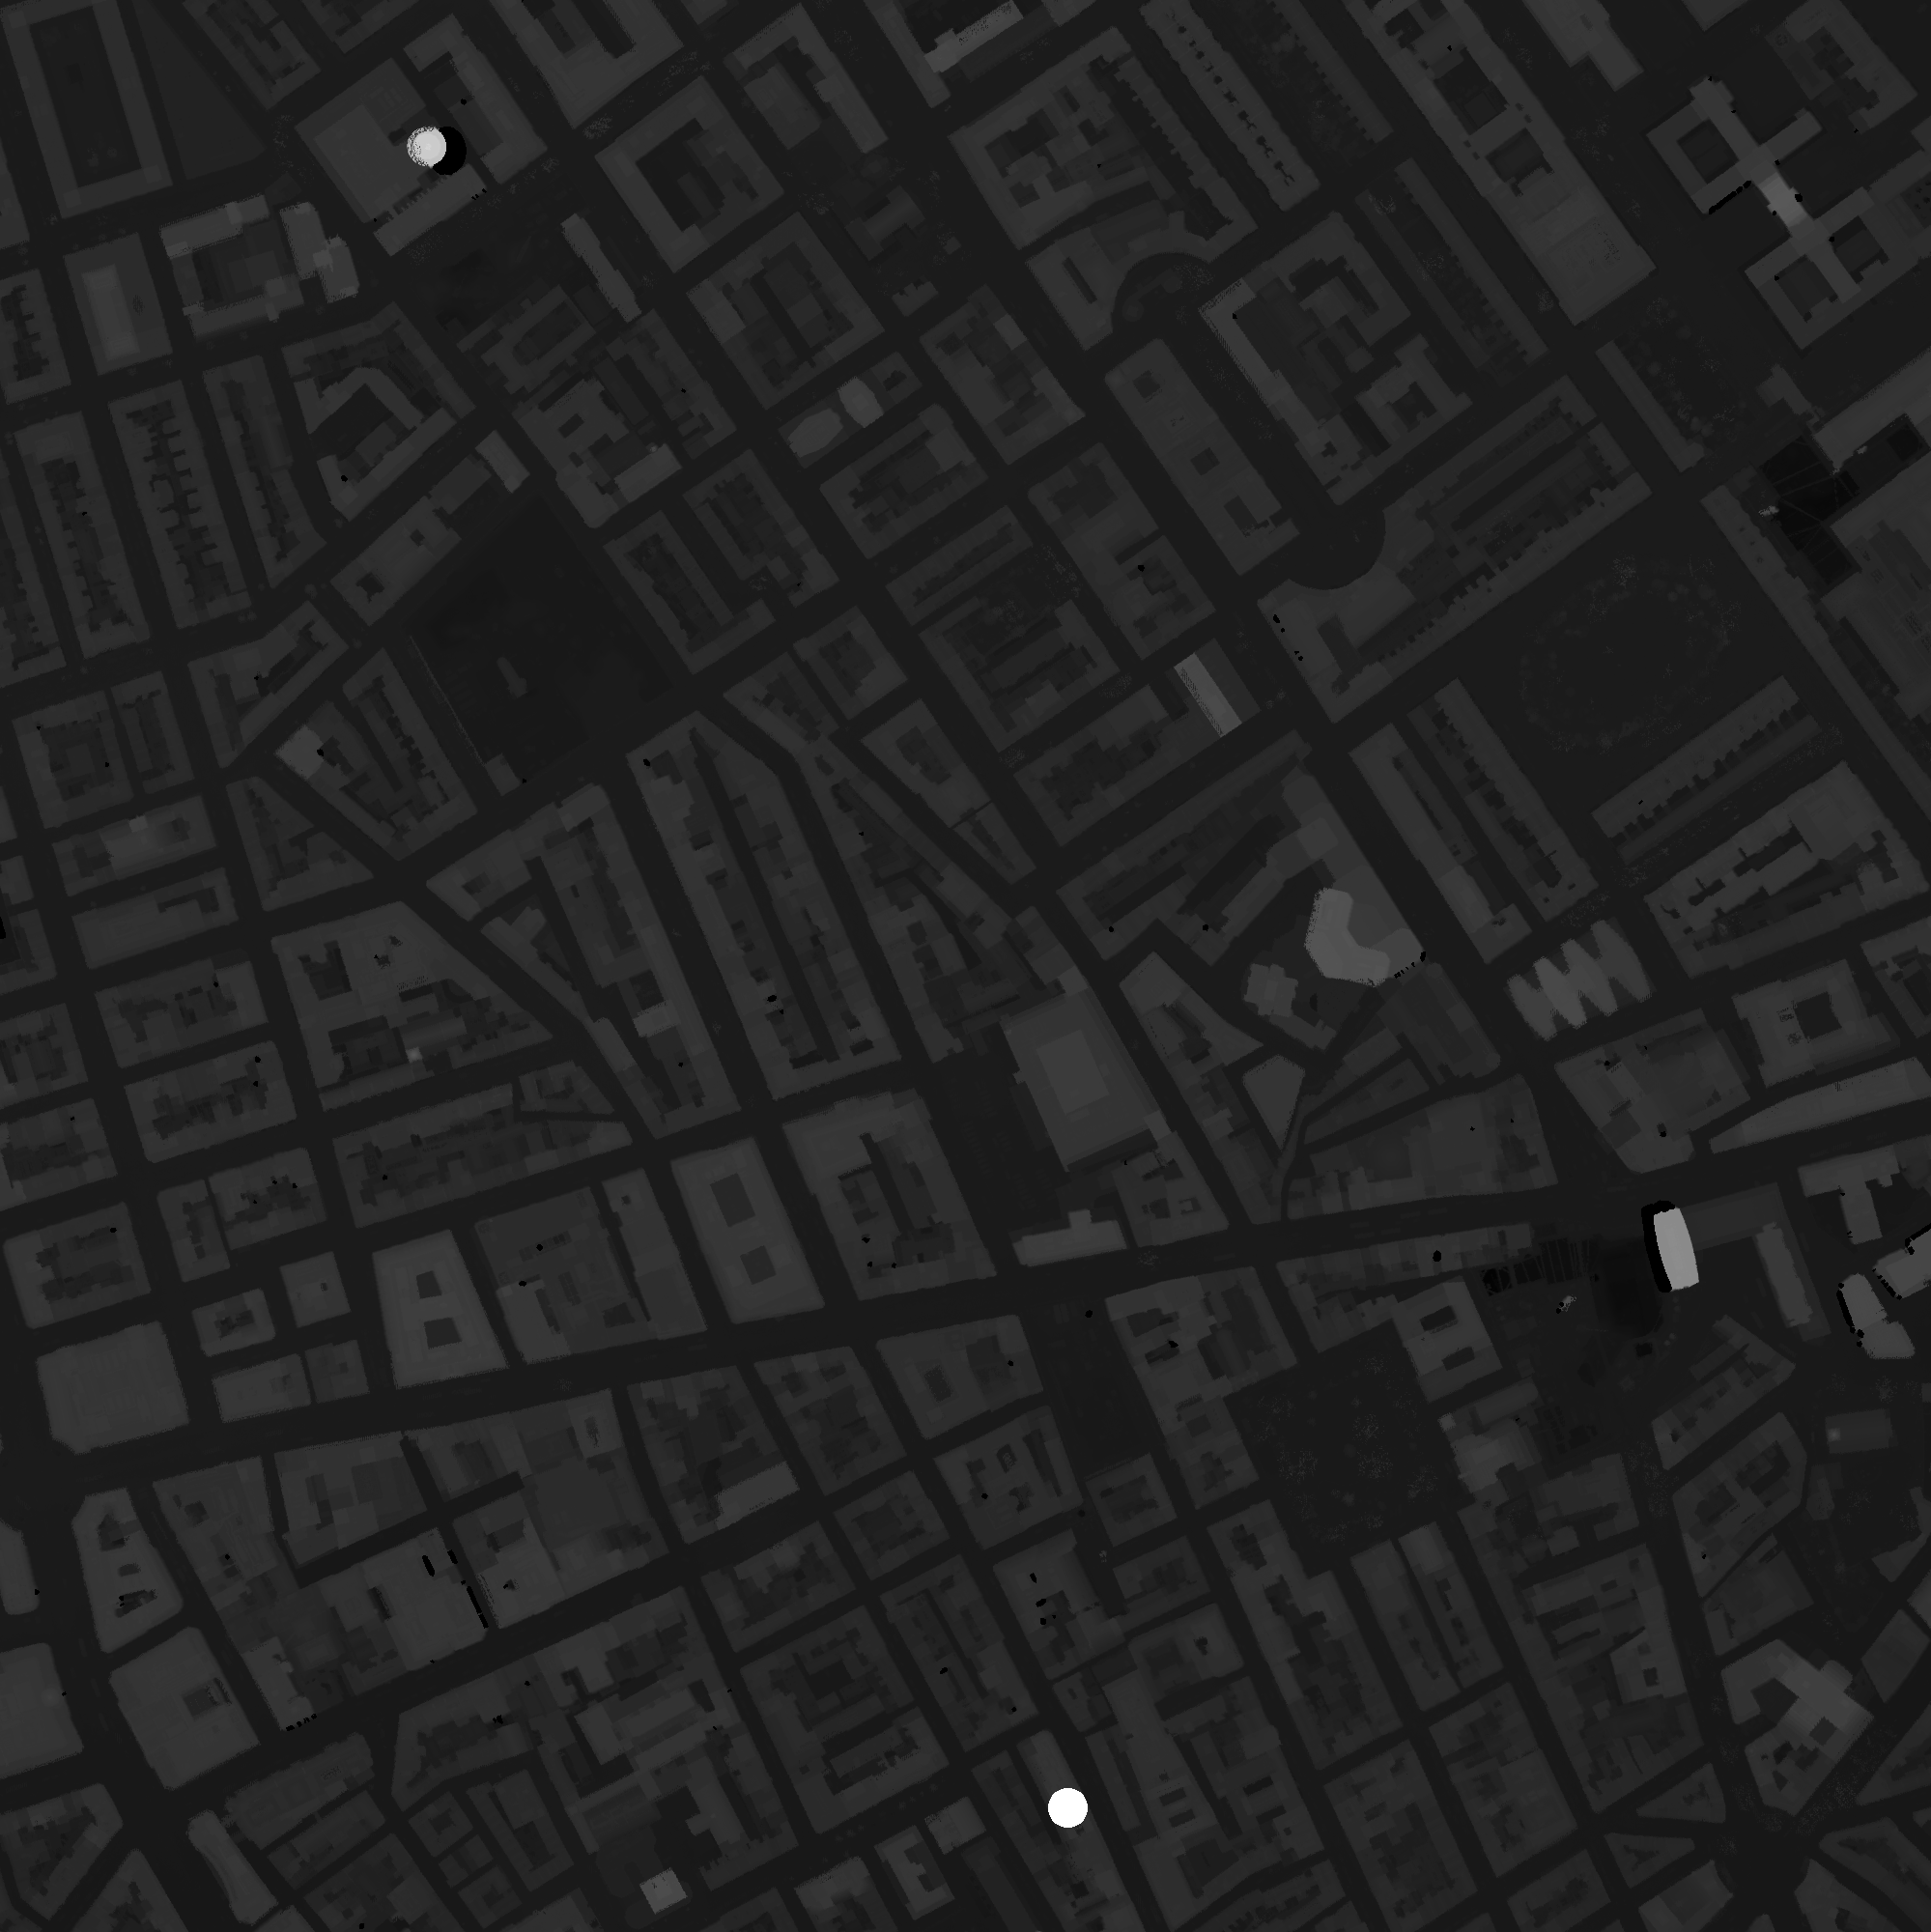

In [10]:
im